In [3]:
from packages import *

In [4]:
data_path = '../DATA/Ruby/'
xlim = [690, 695]
def get_data(T):
  background = pd.read_csv(data_path + f'{T}K_Bac.asc', skiprows=26, names=['Wavelength[nm]', 'Intensity[a.u.]'])
  reference = pd.read_csv(data_path + f'{T}K_Ref.asc', skiprows=26, names=['Wavelength[nm]', 'Intensity[a.u.]'])
  signal = pd.read_csv(data_path + f'{T}K_Sig.asc', skiprows=26, names=['Wavelength[nm]', 'Intensity[a.u.]'])
  mask = (signal['Wavelength[nm]'] > xlim[0]) & (signal['Wavelength[nm]'] < xlim[1])
  signal = signal[mask]
  reference = reference[mask]
  background = background[mask]
  return reference, background, signal


In [5]:
T = 110
ref, bac, sig = get_data(T)

# Curve Fit

[-2.28748888e+05  6.83871200e+02 -1.88621835e-01  1.63224638e+03
  6.92858840e+02  8.93170016e-02]


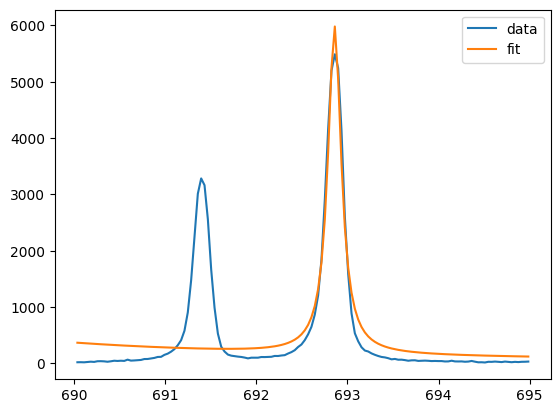

In [6]:
T = ref['Wavelength[nm]']
y = ref['Intensity[a.u.]']

func = lambda x, A1, x1, L1, A2, x2, L2: A1 / np.pi * L1 / (L1**2 + (x - x1)**2) + A2 / np.pi * L2 / (L2**2 + (x - x2)**2)
p0 = [1, 690, 10, 10, 694, 10]

popt, pcov = scipy.optimize.curve_fit(func, T, y, p0=p0)
print(popt)

plt.plot(T, y, label='data')
plt.plot(T, func(T, *popt), label='fit')
plt.legend()

# Torch Fitting

In [7]:
def fit(T, log=False, plot=False, save=False):
  ref, bac, sig = get_data(T)
  x = th.tensor(ref['Wavelength[nm]'].to_numpy())
  y = th.tensor(ref['Intensity[a.u.]'].to_numpy(), dtype=th.float32)

  # peak finding
  range1 = [690, 692]; range2 = [692, 695]
  mask1 = (x > range1[0]) & (x < range1[1]); mask2 = (x > range2[0]) & (x < range2[1])
  y1 = y[mask1]; y2 = y[mask2]
  x = 1239.84193 / x # nm to eV
  peak1 = th.max(y1); peak2 = th.max(y2)
  A1 = peak1; x1 = x[mask1][th.argmax(y1)]; L1 = 4e-4
  A2 = peak2; x2 = x[mask2][th.argmax(y2)]; L2 = 4e-4
  
  # fitting
  func = lambda x, x1, L1, x2, L2: A1 * L1**2 / (L1**2 + (x - x1)**2) + A2 * L2**2 / (L2**2 + (x - x2)**2)
  p0 = th.tensor([x1, L1*1e2, x2, L2*1e2], requires_grad=True)
  params = th.tensor([1, 1e-2, 1, 1e-2], requires_grad=True)

  optimizer = th.optim.Adam([params], lr=5e-4, weight_decay=1e-5)

  for epoch in range(1000):
    optimizer.zero_grad()
    loss = th.mean((func(x, *(p0*params)) - y)**2)
    loss.backward()
    optimizer.step()
  if log:
    print('RMSE Error : ', np.sqrt(loss.item()))
  result = (params*p0)

  peak1 = A1.item(); peak2 = A2.item()
  mid1 = result[0].detach().numpy(); mid2 = result[2].detach().numpy()
  width1 = result[1].detach().numpy(); width2 = result[3].detach().numpy()
  area1 = A1.item()*result[1].detach().numpy() / np.pi; area2 = A2.item()*result[3].detach().numpy() / np.pi
  ratio = (A1.item()*result[1].detach().numpy() / np.pi) / (A2.item()*result[3].detach().numpy() / np.pi)
  R2 = 1 - loss.item() / ((y - y.mean())**2).mean()

  if log:
    print(f'Peak1 : {peak1:.2f}, Centre1 : {mid1:.4f}, Width1 : {width1:.4f}, Area1 : {area1:.2f}')
    print(f'Peak2 : {peak2:.2f}, Centre2 : {mid2:.4f}, Width2 : {width2:.4f}, Area2 : {area2:.2f}')
    print(f'Ratio : {ratio:.2f}')
    print(f'R2 : {R2:.2f}')
  if plot or save:
    plt.plot(x, y, label='data', color='black')
    plt.plot(x, func(x, *(p0*params).detach().numpy()), label='fit', color='red', linestyle='--')
    plt.title(f'Photoluminescence of ruby at {T}K')
    plt.xlabel('Energy[eV]')
    plt.ylabel('Intensity[a.u.]')
    plt.text(1.784, peak2*0.7, f"""RMSE: {np.sqrt(loss.item()):.0f}[a.u.]
Peak1: {peak1:.0f}[a.u.]
Centre1: {mid1:.3f}[eV]
Peak2: {peak2:.0f}[a.u.]
Centre2: {mid2:.3f}[eV]
Ratio: {ratio:.2f}""")
    plt.legend()
    if save:
      plt.savefig(f'output/Ruby_Fit/{T}K.png', dpi=400)
    if plot:
      plt.show()
    plt.close()
  return [np.sqrt(loss.item()), peak1, mid1, width1, area1, peak2, mid2, width2, area2, ratio]

In [8]:
data = []
Temperature = np.arange(10, 300, 10)
for T in Temperature:
  data.append(fit(T, log=False, plot=False, save=True))
data = np.array(data)
data.shape

(29, 10)

RMSE Error :  21.65339316807108
Peak1 : 2153.00, Centre1 : 1.7923, Width1 : 0.0004, Area1 : 0.29
Peak2 : 2952.00, Centre2 : 1.7885, Width2 : 0.0005, Area2 : 0.50
Ratio : 0.58
R2 : 1.00


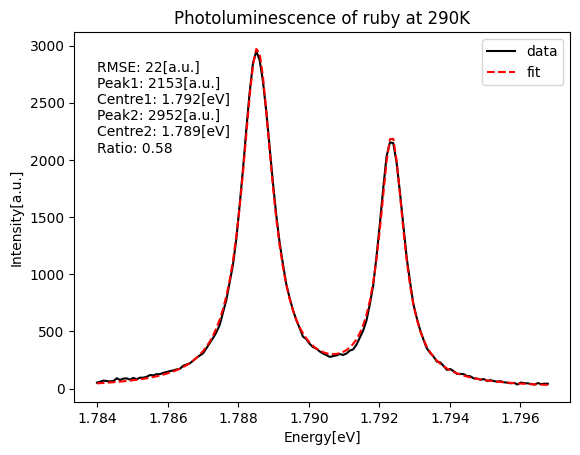

[21.65339316807108,
 2153.0,
 array(1.79234666),
 array(0.0004247),
 0.291056294892279,
 2952.0,
 array(1.7885328),
 array(0.00053042),
 0.49840738256191136,
 0.5839726799314103]

In [9]:
fit(290, log=True, plot=True, save=True)

RMSE Error :  21.65339316807108
Peak1 : 2153.00, Centre1 : 1.7923, Width1 : 0.0004, Area1 : 0.29
Peak2 : 2952.00, Centre2 : 1.7885, Width2 : 0.0005, Area2 : 0.50
Ratio : 0.58
R2 : 1.00


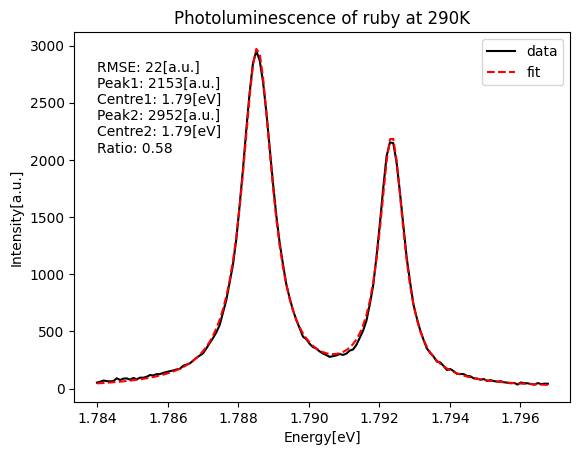

In [10]:
T = 290; log = True; plot = True; save = True
ref, bac, sig = get_data(T)
x = th.tensor(ref['Wavelength[nm]'].to_numpy())
y = th.tensor(ref['Intensity[a.u.]'].to_numpy(), dtype=th.float32)

# peak finding
range1 = [690, 692]; range2 = [692, 695]
mask1 = (x > range1[0]) & (x < range1[1]); mask2 = (x > range2[0]) & (x < range2[1])
y1 = y[mask1]; y2 = y[mask2]
x = 1239.84193 / x # nm to eV
peak1 = th.max(y1); peak2 = th.max(y2)
A1 = peak1; x1 = x[mask1][th.argmax(y1)]; L1 = 4e-4
A2 = peak2; x2 = x[mask2][th.argmax(y2)]; L2 = 4e-4

# fitting
func = lambda x, x1, L1, x2, L2: A1 * L1**2 / (L1**2 + (x - x1)**2) + A2 * L2**2 / (L2**2 + (x - x2)**2)
p0 = th.tensor([x1, L1*1e2, x2, L2*1e2], requires_grad=True)
params = th.tensor([1, 1e-2, 1, 1e-2], requires_grad=True)

optimizer = th.optim.Adam([params], lr=5e-4, weight_decay=1e-5)

for epoch in range(1000):
  optimizer.zero_grad()
  loss = th.mean((func(x, *(p0*params)) - y)**2)
  loss.backward()
  optimizer.step()
if log:
  print('RMSE Error : ', np.sqrt(loss.item()))
result = (params*p0)

peak1 = A1.item(); peak2 = A2.item()
mid1 = result[0].detach().numpy(); mid2 = result[2].detach().numpy()
width1 = result[1].detach().numpy(); width2 = result[3].detach().numpy()
area1 = A1.item()*result[1].detach().numpy() / np.pi; area2 = A2.item()*result[3].detach().numpy() / np.pi
ratio = (A1.item()*result[1].detach().numpy() / np.pi) / (A2.item()*result[3].detach().numpy() / np.pi)
R2 = 1 - loss.item() / ((y - y.mean())**2).mean()

if log:
  print(f'Peak1 : {peak1:.2f}, Centre1 : {mid1:.4f}, Width1 : {width1:.4f}, Area1 : {area1:.2f}')
  print(f'Peak2 : {peak2:.2f}, Centre2 : {mid2:.4f}, Width2 : {width2:.4f}, Area2 : {area2:.2f}')
  print(f'Ratio : {ratio:.2f}')
  print(f'R2 : {R2:.2f}')
if plot or save:
  plt.plot(x, y, label='data', color='black')
  plt.plot(x, func(x, *(p0*params).detach().numpy()), label='fit', color='red', linestyle='--')
  plt.title(f'Photoluminescence of ruby at {T}K')
  plt.xlabel('Energy[eV]')
  plt.ylabel('Intensity[a.u.]')
  plt.text(1.784, peak2*0.7, f"""RMSE: {np.sqrt(loss.item()):.0f}[a.u.]
Peak1: {peak1:.0f}[a.u.]
Centre1: {mid1:.2f}[eV]
Peak2: {peak2:.0f}[a.u.]
Centre2: {mid2:.2f}[eV]
Ratio: {ratio:.2f}""")
  plt.legend()
  if save:
    plt.savefig(f'output/Ruby_Fit/RT_fit.png', dpi=400)
  if plot:
    plt.show()
  plt.close()

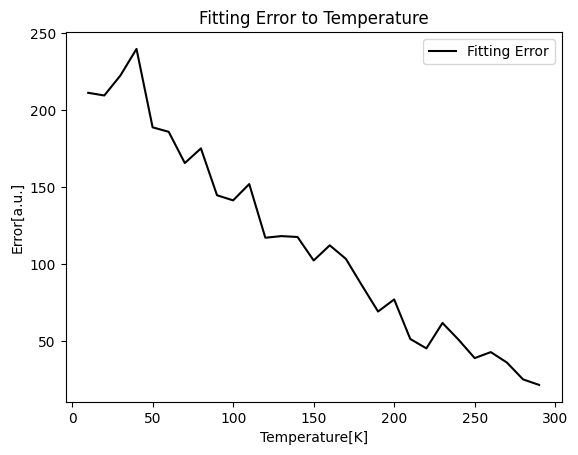

In [11]:
plt.title('Fitting Error to Temperature')
plt.plot(Temperature, data[:, 0], label='Fitting Error', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('Error[a.u.]')
plt.legend()
plt.savefig('output/Ruby_EDA/Error.png', dpi=400)
plt.show()

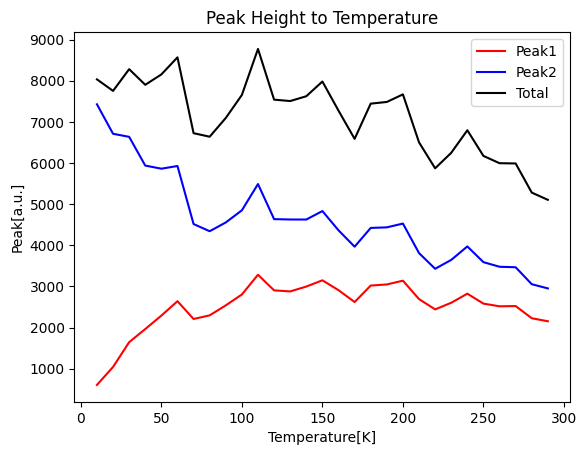

In [12]:
plt.title('Peak Height to Temperature')
plt.plot(Temperature, data[:, 1], label='Peak1', color='red')
plt.plot(Temperature, data[:, 5], label='Peak2', color='blue')
plt.plot(Temperature, data[:, 1] + data[:, 5], label='Total', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('Peak[a.u.]')
plt.legend()
plt.savefig('output/Ruby_EDA/Peak.png', dpi=400)
plt.show()

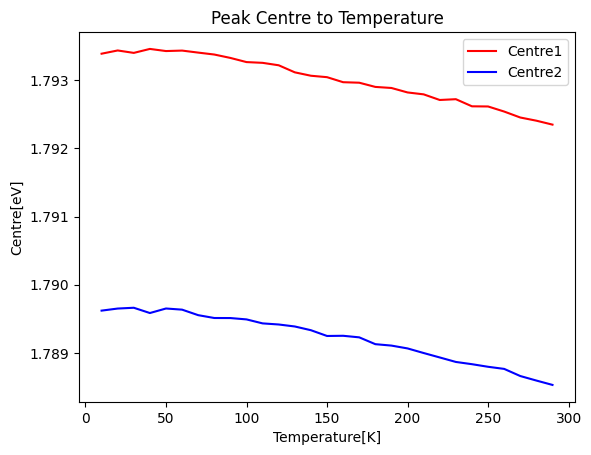

In [13]:
plt.title('Peak Centre to Temperature')
plt.plot(Temperature, data[:, 2], label='Centre1', color='red')
plt.plot(Temperature, data[:, 6], label='Centre2', color='blue')
plt.xlabel('Temperature[K]')
plt.ylabel('Centre[eV]')
plt.legend()
plt.savefig('output/Ruby_EDA/Centre.png', dpi=400)
plt.show()

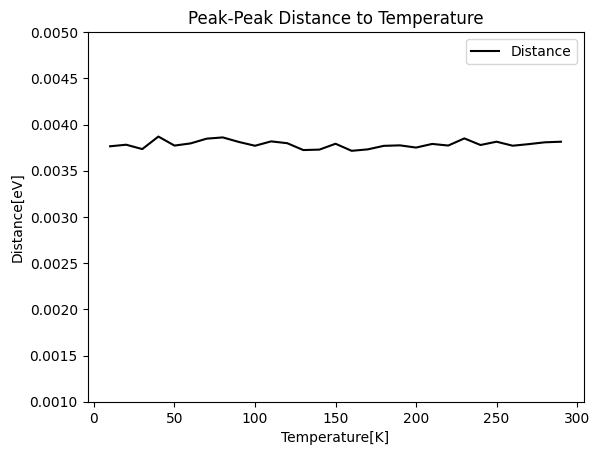

In [14]:
plt.title('Peak-Peak Distance to Temperature')
plt.plot(Temperature,  data[:, 2] - data[:, 6], label='Distance', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('Distance[eV]')
plt.ylim(1e-3, 5e-3)
plt.legend()
plt.savefig('output/Ruby_EDA/Distance.png', dpi=400)
plt.show()

In [15]:
energy_gap = np.mean(data[:, 2] - data[:, 6])
energy_gap

0.0037859148917085417

/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_83618/3377509537.py:6: RuntimeWarning: overflow encountered in exp
  integral = np.sum(x**6 * np.exp(x) / (np.exp(x) - 1 + eps)**2) * (T_D/T / 10000)
/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_83618/3377509537.py:6: RuntimeWarning: overflow encountered in multiply
  integral = np.sum(x**6 * np.exp(x) / (np.exp(x) - 1 + eps)**2) * (T_D/T / 10000)
/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_83618/3377509537.py:6: RuntimeWarning: overflow encountered in square
  integral = np.sum(x**6 * np.exp(x) / (np.exp(x) - 1 + eps)**2) * (T_D/T / 10000)
/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_83618/3377509537.py:6: RuntimeWarning: invalid value encountered in divide
  integral = np.sum(x**6 * np.exp(x) / (np.exp(x) - 1 + eps)**2) * (T_D/T / 10000)


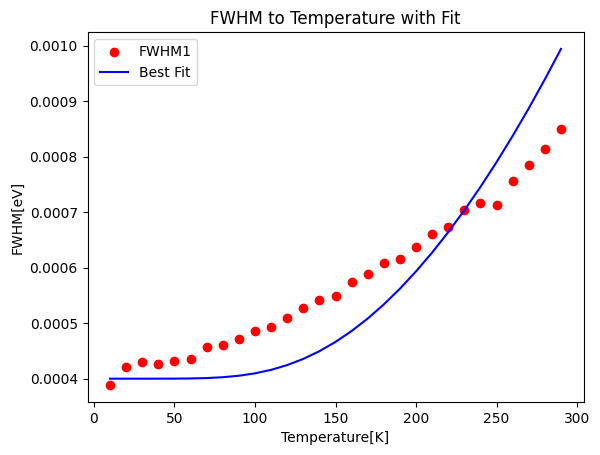

In [20]:
Gamma_n = 2e-4 *2
def func(T, alpha_n, T_D):
  eps = 1e-11
  h = 1e-3
  x = np.linspace(0, T_D/T, 10000)
  integral = np.sum(x**6 * np.exp(x) / (np.exp(x) - 1 + eps)**2) * (T_D/T / 10000)
  return  Gamma_n + alpha_n * (T / T_D) ** 7 * integral

p0 = [3e-2, 760]
popt, pcov = scipy.optimize.curve_fit(func, data[:, 0], data[:, 3]*2, p0=p0)

plt.title('FWHM to Temperature with Fit')
plt.scatter(Temperature, data[:, 3]*2, label='FWHM1', color='red')
plt.plot(Temperature, [func(x, *p0) for x in Temperature], label='Best Fit', color='blue')
# plt.plot(Temperature, [func(x, *popt) for x in Temperature], label='Width2', color='black')
plt.xlabel('Temperature[K]')
plt.ylabel('FWHM[eV]')
plt.legend()
plt.savefig('output/Ruby_EDA/FWHM_Fit.png', dpi=400)
plt.show()

In [21]:
popt

array([1.73168344e+00, 3.95794846e+03])

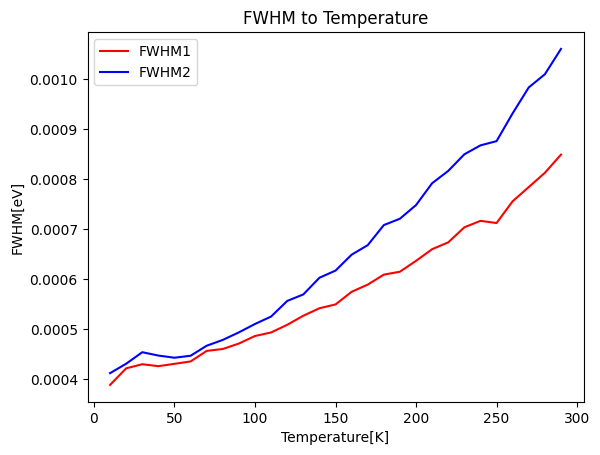

In [22]:
plt.title('FWHM to Temperature')
plt.plot(Temperature, data[:, 3]*2, label='FWHM1', color='red')
plt.plot(Temperature, data[:, 7]*2, label='FWHM2', color='blue')
plt.xlabel('Temperature[K]')
plt.ylabel('FWHM[eV]')
plt.legend()
plt.savefig('output/Ruby_EDA/FWHM.png', dpi=400)
plt.show()

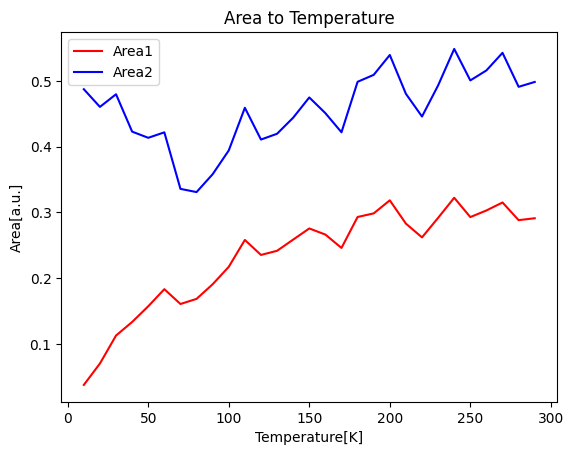

In [ ]:
plt.title('Area to Temperature')
plt.plot(Temperature, data[:, 4], label='Area1', color='red')
plt.plot(Temperature, data[:, 8], label='Area2', color='blue')
plt.xlabel('Temperature[K]')
plt.ylabel('Area[a.u.]')
plt.legend()
plt.savefig('output/Ruby_EDA/Area.png', dpi=400)
plt.show()

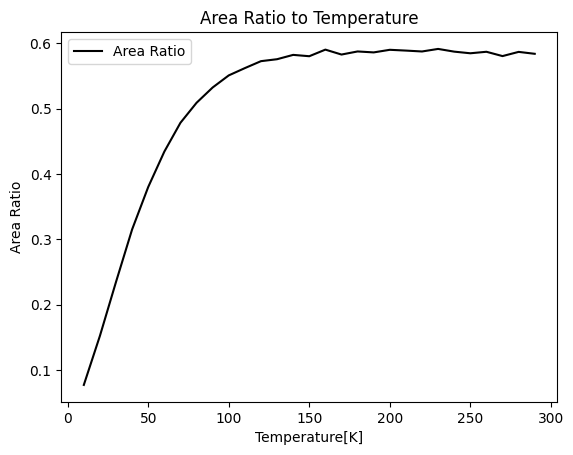

In [11]:
plt.title('Area Ratio to Temperature')
k_B = 8.617333262145e-5 # eV/K
A = 0.58
func = lambda T, delta_E: A * np.exp(-delta_E / (k_B * T))
p0 = [1e-3]
popt, pcov = scipy.optimize.curve_fit(func, data[:, 0], data[:, 9], p0=p0)
plt.plot(Temperature, data[:, 9], label='Area Ratio', color='black')
# plt.plot(Temperature, func(Temperature, *p0), label='Expoential fit', color='red', linestyle='--')
# plt.plot(Temperature, func(Temperature, *popt), label='fit', color='red', linestyle='--')

mask = data[:, 9] < 0.4
lin = lambda T, a, b: a * T + b
popt, pcov = scipy.optimize.curve_fit(lin, data[mask, 0], data[mask, 9])
# plt.plot(data[:8, 0], lin(data[:8, 0], *popt), label='Linear fit', color='blue', linestyle='--')

plt.xlabel('Temperature[K]')
plt.ylabel('Area Ratio')
plt.legend()
plt.savefig('output/Ruby_EDA/Ratio.png', dpi=400)
plt.show()

In [23]:
A = np.mean(data[:, 9][-10:])
A

0.5868520329806074

[6.93614275 0.04004428]


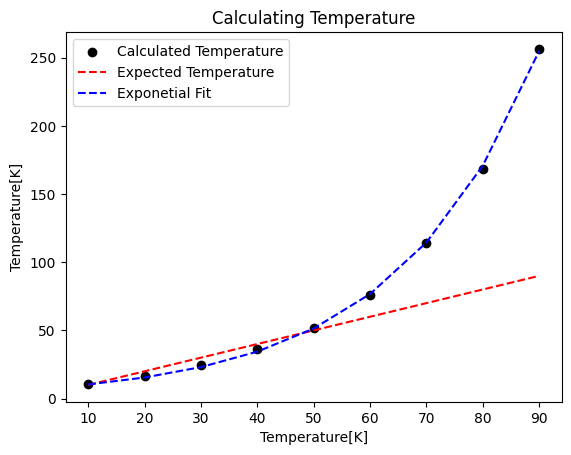

In [57]:
ratio = data[:-20, 9]
k_B = 8.617333262145e-5 # eV/K
new_T = -energy_gap / (k_B * np.log(ratio / A)) / 2

func = lambda t, a, b: a * np.exp(b*t)
p0 = [1, 1e-5]
popt, pcov = scipy.optimize.curve_fit(func, Temperature[:-20], new_T, p0=p0)
print(popt)

plt.scatter(Temperature[:-20], new_T, label='Calculated Temperature', color='black')
plt.plot(Temperature[:-20], Temperature[:-20], label='Expected Temperature', color='red', linestyle='--')

plt.plot(Temperature[:-20], func(Temperature[:-20], *popt), label='Exponetial Fit', color='blue', linestyle='--')
plt.xlabel('Temperature[K]')
plt.ylabel('Temperature[K]')
plt.legend()
plt.title('Calculating Temperature')
plt.savefig('output/Ruby_EDA/Calculating Temperature.png', dpi=400)
plt.show()



In [ ]:
popt[0]

0.0023042728658853448